In [128]:
import numpy as np
import pysindy as ps
from pysindy import SINDy
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from pysindy.optimizers import STLSQ


Loading the data from the Kaggle dataset

In [129]:
data = np.genfromtxt('/home/luka/Desktop/projekti/sindy_tutorial/archive/reconstruction/train.csv', delimiter=',', skip_header=1)

Extracting the variables from the dataset

In [130]:
t = data[:, 0]
X = data[:, 1:3]

#time step
dt = t[1] - t[0]

Let's see what SINDy identifies by default. We use the STSLQ as an L1 regularization in the sparse regression.

In [131]:
from pysindy.feature_library import PolynomialLibrary, FourierLibrary

model1 = SINDy(optimizer=STLSQ(threshold=0.01))

# Naming the variables
model1.fit(X, t=dt, feature_names=["x", "v"])

model1.print()
print("Model score (R^2):", model1.score(X, t=dt))

(x)' = -0.072 x +  0.672 v + -0.320 x^2 +  0.432 x v +  0.133 v^2
(v)' = -0.754 x + -0.030 v + -0.280 x^2 +  0.378 x v +  0.116 v^2
Model score (R^2): 0.953923833974492


By default, SINDy uses the polinomial library, up to the polynomials of second degree.

In [132]:
feature_names = model1.get_feature_names()
print("Functions in the Theta library:", feature_names)

Functions in the Theta library: ['1', 'x', 'v', 'x^2', 'x v', 'v^2']


Now, let's modify the Theta library (containing basis functions). Alongside polinomials, we will add sin/cos basis (Fourie library). Then, we will see if the identified system is changed:

In [133]:

# Joining the Polynomial and Fourier library
combined_lib = PolynomialLibrary(degree=2) + FourierLibrary(n_frequencies=1)

model2 = SINDy(feature_library=combined_lib,optimizer=STLSQ(threshold=0.1))
model2.fit(X, t=dt, feature_names=["x", "v"])

model2.print()
print("Model score (R^2):", model2.score(X, t=dt))

(x)' = -2.602 x +  0.428 v + -0.193 x^2 +  0.114 x v +  2.733 sin(1 x) +  0.282 sin(1 v)
(v)' = -0.758 x + -0.250 x^2 +  0.186 x v
Model score (R^2): 0.9677484539973241


We now see, that on the observed scope, SINDy finds the usage of sin(x) justified. For this specific problem, it is known from physics that sin and cos are not contained in the solution. We now compare predicted paths from models with and without Fourier basis for the first 100 steps:

Simulation in progress...
Simulation complete!


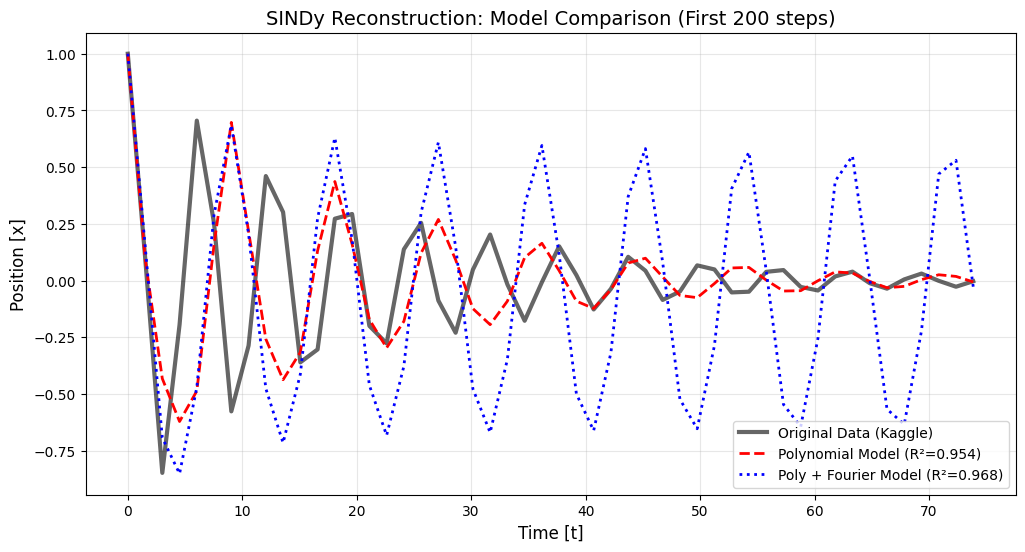

In [ ]:
# --- 1. SIMULATION ---
# We simulate the first 100 points for a quick performance check
num_steps = 50 
t_test = t[:num_steps]

print("Simulation in progress...")
# model1: Polynomial library only
x_sim_poly = model1.simulate(X[0], t_test)

# model2: Combined Polynomial + Fourier library
x_sim_combined = model2.simulate(X[0], t_test)
print("Simulation complete!")

# --- 2. TIME SERIES PLOT ---
plt.figure(figsize=(12, 6))

# Original Data (Target)
plt.plot(t_test, X[:num_steps, 0], 'k', alpha=0.6, lw=3, label='Original Data (Kaggle)')

# Model 1 reconstruction
plt.plot(t_test, x_sim_poly[:, 0], 'r--', lw=2, label=f'Polynomial Model (R²={model1.score(X, t=dt):.3f})')

# Model 2 reconstruction
plt.plot(t_test, x_sim_combined[:, 0], 'b:', lw=2, label=f'Poly + Fourier Model (R²={model2.score(X, t=dt):.3f})')

plt.title("SINDy Reconstruction: Model Comparison (First 50 steps)", fontsize=14)
plt.xlabel("Time [t]", fontsize=12)
plt.ylabel("Position [x]", fontsize=12)
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()


We can also evaluate x' against t:

TODO: Testing the detected model with AIC (akkaike information criteria), BIC (Bayesian ...), and plotting the models for different lambdas. 